Spherical harmonics

https://lianera.github.io/2016/sh-lighting-exp/

https://en.wikipedia.org/wiki/Spherical_harmonics

https://en.wikipedia.org/wiki/Cube_mapping

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib inline
# 可旋转plot
%matplotlib notebook

In [217]:
def convert_cube_uv_to_xyz(axis, u, v):
    #convert range 0 to 1 to -1 to 1
    uc = 2.0 * u - 1.0
    vc = 2.0 * v - 1.0
    if   axis == "+X":
        return   1, vc, -uc   # POSITIVE X
    elif axis == "-X":
        return  -1, vc,  uc   # NEGATIVE X
    elif axis == "+Y":
        return  uc,  1, -vc   # POSITIVE Y
    elif axis == "-Y":
        return  uc, -1,  vc   # NEGATIVE Y
    elif axis == "+Z":
        return  uc, vc,   1   # POSITIVE Z
    elif axis == "-Z":
        return -uc, vc,  -1   # NEGATIVE Z

def getPoints_uv_to_xyz(num, axis):
    X,Y,Z = [],[],[]
    for i in range(num + 1):
        for j in range(num + 1):
            u, v = i / num, j / num
            x, y, z = convert_cube_uv_to_xyz(axis, u, v)
            
            # normalized
            r = math.sqrt(x*x + y*y + z*z)
            x, y, z = x/r, y/r, z/r
            
            #print(u,v,x,y,z,r)
            
            X.append(x)
            Y.append(y)
            Z.append(z) 
    return X, Y, Z

def plotScatter_uv_to_xyz(num, axisSettings):
    # 定义figure
    fig = plt.figure()
    # 将figure变为3d
    ax = Axes3D(fig)
    
    for axis, color in axisSettings.items():
        X,Y,Z = getPoints_uv_to_xyz(num, axis)
        ax.scatter(X, Y, Z, c=color, marker='o', s=10)
    
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.set_title("Cube map uv to xyz", alpha=0.6, color="#0000ff", size=16, weight='bold', backgroundcolor="y")
    plt.show()

<IPython.core.display.Javascript object>


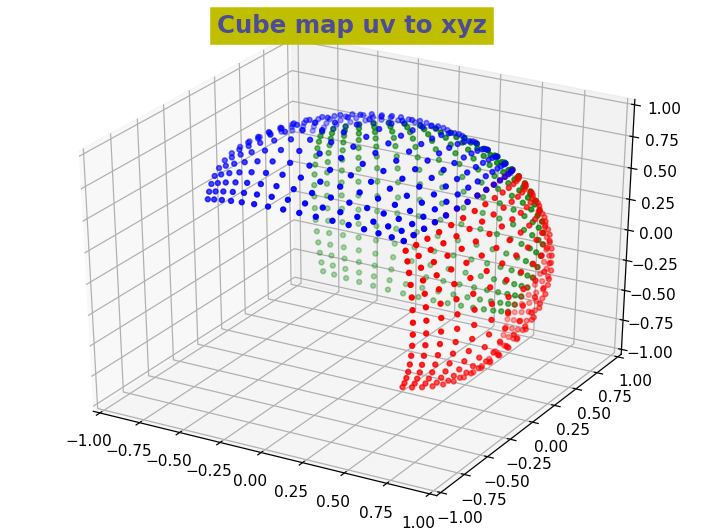

In [218]:
axisSettings = {"+X":"r", "+Y":"g", "+Z":"b"}
plotScatter_uv_to_xyz(15, axisSettings)

In [302]:
maxLayerSH = 16
basisSH = np.zeros(maxLayerSH)
coefSH = np.zeros(maxLayerSH)

def SH4(x, y, z, r):
    basisSH[0] = 1 / 2 * math.sqrt(1 / np.pi)
    basisSH[1] = math.sqrt(3 / (4 * np.pi)) * y / r
    basisSH[2] = math.sqrt(3 / (4 * np.pi)) * z / r
    basisSH[3] = math.sqrt(3 / (4 * np.pi)) * x / r

def SH9(x, y, z, r):    
    SH4(x, y, z, r)
    r2 = r*r
    basisSH[4] = 1 / 2 * math.sqrt(15 / np.pi) * x * y / r2
    basisSH[5] = 1 / 2 * math.sqrt(15 / np.pi) * y * z / r2
    basisSH[6] = 1 / 4 * math.sqrt(5/ np.pi) * (-x*x - y*y + 2 * z*z) / r2
    basisSH[7] = 1 / 2 * math.sqrt(15 / np.pi) * z * x / r2
    basisSH[8] = 1 / 4 * math.sqrt(15 / np.pi) * (x*x - y*y) / r2

def SH16(x, y, z, r):    
    SH9(x, y, z, r)
    x2, y2, z2, r3 = x * x, y * y, z * z, r * r * r
    basisSH[9] = 1 / 4 * math.sqrt(35 / (2 * np.pi)) * (3 * x2 - y2) * y / r3
    basisSH[10] = 1 / 2 * math.sqrt(105 / np.pi) * x * y * z / r3
    basisSH[11] = 1 / 4 * math.sqrt(21 / (2 * np.pi)) * y * (4 * z2 - x2 - y2) / r3
    basisSH[12] = 1 / 4 * math.sqrt(7 / np.pi) * z * (2 * z2 - 3 * x2 - 3 * y2) / r3
    basisSH[13] = 1 / 4 * math.sqrt(21 / (2 * np.pi)) * x * (4 * z2 - x2 - y2) / r3
    basisSH[14] = 1 / 4 * math.sqrt(105 / np.pi) * (x2 - y2) * z / r3
    basisSH[15] = 1 / 4 * math.sqrt(35 / (2 * np.pi)) * (x2 - 3 * y2) * x / r3
    
def ForwardSumSH(x, y, z, r, funcSH): 
    funcSH(x, y, z, r)
    for i in range(maxLayerSH):
        coefSH[i] += basisSH[i]

def BackCalculateL(x, y, z, r, funcSH): 
    funcSH(x, y, z, r)
    L = 0
    for i in range(maxLayerSH):
        L += coefSH[i] * basisSH[i]
    return L
        
def NormalizedCoefficient(N):
    for i in range(len(coefSH)):
        coefSH[i] *= 4 * np.pi / N

def plotScatter_SH(num, axisSettings, title, scale, funcSH):
    # 定义figure
    fig = plt.figure()
    # 将figure变为3d
    ax = Axes3D(fig)
    
    for axis, color in axisSettings.items():
        X,Y,Z = getPoints_uv_to_xyz(num, axis)
        
        # clear cache
        for i in range(maxLayerSH):
            basisSH[i] = 0
        for i in range(maxLayerSH):
            coefSH[i] = 0
 
        N = len(X)
    
        # integral all points: Ci = ∑L(x,y,z)Yi(x,y,z,r), where L(x,y,z) = 1 and r = 1, so => Ci = ∑Yi(x,y,z,1)
        for i in range(N):
            ForwardSumSH(X[i], Y[i], Z[i], 1, funcSH)
            
        # normalize coefficients
        NormalizedCoefficient(N)
        
        # calculate output L for every point: L = ∑CiYi(x,y,z,r), where r = 1, so => L = ∑CiYi(x,y,z,1)
        for i in range(N):
            L = BackCalculateL(X[i], Y[i], Z[i], 1, funcSH)

            # scale vector(x,y,z) by L
            X[i], Y[i], Z[i] = X[i] * L, Y[i] * L, Z[i] * L

        ax.scatter(X, Y, Z, c=color, marker='o', s=10)
    
    ax.set_xlim(-scale, scale)
    ax.set_ylim(-scale, scale)
    ax.set_zlim(-scale, scale)
    ax.set_title(title, alpha=0.6, color="#0000ff", size=16, weight='bold', backgroundcolor="y")
    plt.show()

<IPython.core.display.Javascript object>


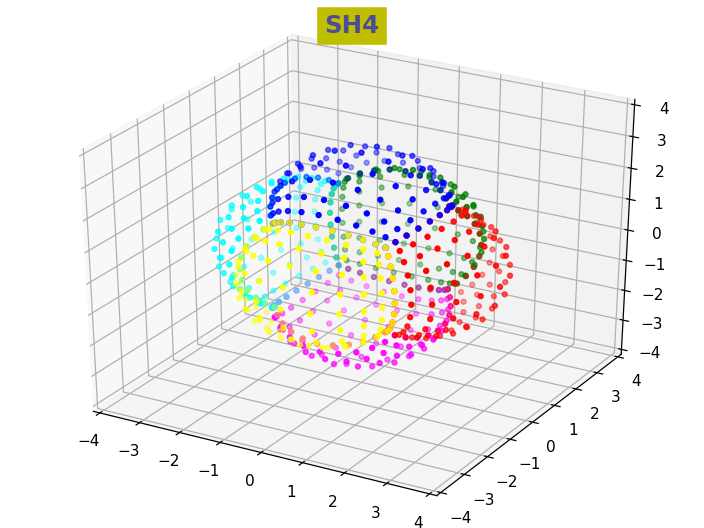

In [303]:
axisSettings = {"+X":"r", "+Y":"g", "+Z":"b", "-X":"#00ffff", "-Y":"#ffff00", "-Z":"#ff00ff"}
plotScatter_SH(10, axisSettings, "SH4", 4, SH4)

<IPython.core.display.Javascript object>


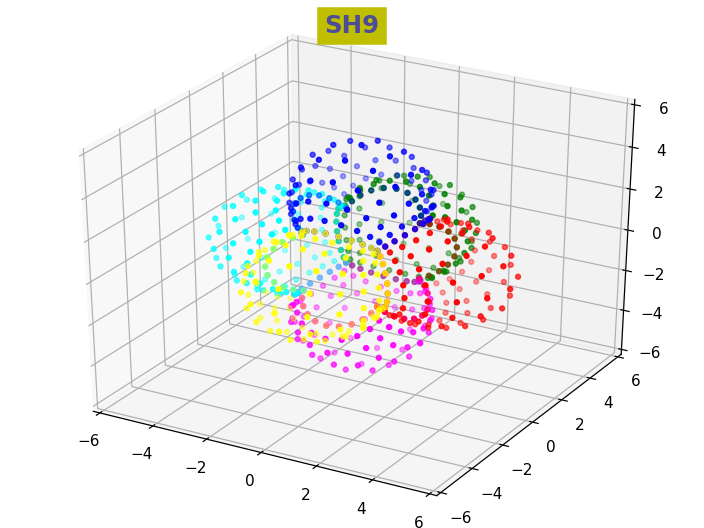

In [304]:
axisSettings = {"+X":"r", "+Y":"g", "+Z":"b", "-X":"#00ffff", "-Y":"#ffff00", "-Z":"#ff00ff"}
plotScatter_SH(10, axisSettings, "SH9", 6, SH9)

<IPython.core.display.Javascript object>


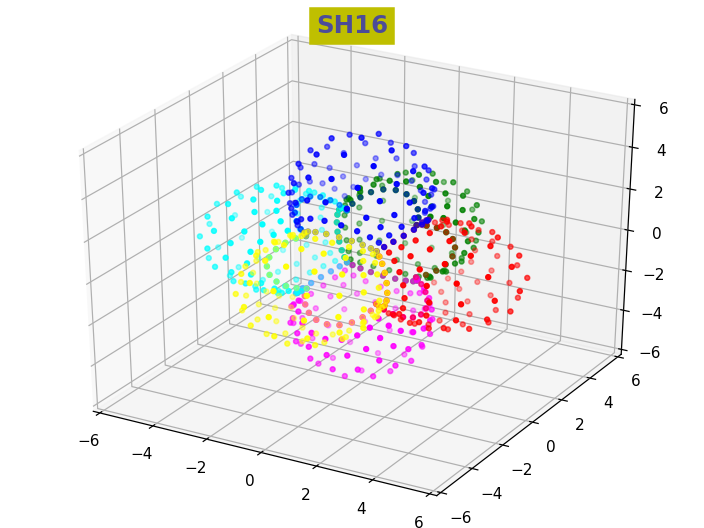

In [305]:
axisSettings = {"+X":"r", "+Y":"g", "+Z":"b", "-X":"#00ffff", "-Y":"#ffff00", "-Z":"#ff00ff"}
plotScatter_SH(10, axisSettings, "SH16", 6, SH16)